## Import packages 

In [140]:
import lightgbm as lgb
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import spacy

from platform import python_version
from sklearn.metrics import f1_score
from spacy import displacy
from spacy.util import minibatch, compounding

%matplotlib inline

In [141]:
# Python version
print(f'python=={python_version()}')
# Package versions
print(f'lightgbm=={lgb.__version__}')
print(f'matplotlib=={matplotlib.__version__}')
print(f'numpy=={np.__version__}')
print(f'pandas=={pd.__version__}')
print(f'spacy=={spacy.__version__}')
print(f'sklearn=={sklearn.__version__}')

python==3.7.4
lightgbm==2.3.0
matplotlib==3.1.1
numpy==1.17.2
pandas==0.24.2
spacy==2.2.4
sklearn==0.21.3


## Load data

In [142]:
drug_reviews_train = pd.read_csv('drugLibTrain_raw.tsv', sep='\t')
drug_reviews_train.shape

(3107, 9)

In [143]:
drug_reviews_test = pd.read_csv('drugLibTest_raw.tsv', sep='\t')
drug_reviews_test.shape

(1036, 9)

In [144]:
drug_reviews_train['category'] = 'train'
drug_reviews_test['category'] = 'test'
drug_reviews = pd.concat([drug_reviews_train, drug_reviews_test], sort = False)

In [145]:
drug_reviews = drug_reviews[['urlDrugName',
                             'rating',
                             'effectiveness',
                             'sideEffects',
                             'condition',
                             'benefitsReview',
                             'sideEffectsReview',
                             'commentsReview',
                             'category']].dropna()
drug_reviews.shape

(4132, 9)

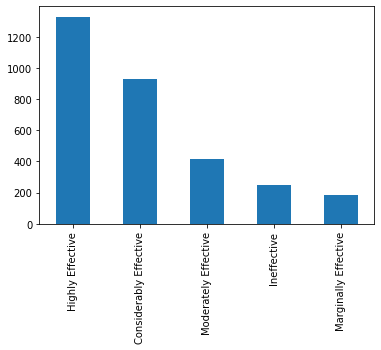

In [44]:
effectiveness_barplot = drug_reviews_train.effectiveness.value_counts().plot(kind = 'bar')
effectiveness_figure = effectiveness_barplot.get_figure()

'Moderately Effective', 'Ineffective' and 'Marginally Effective' contain notably less data than the other two columns. Join 'Highly Effective' and 'Considerably Effective' and oppose those columns to the rest of the values, to make the data slightly more balanced.

In [46]:
drug_reviews['effectiveScore'] = drug_reviews.apply(lambda row: (
    row.effectiveness == 'Highly Effective' or 
    row.effectiveness == 'Considerably Effective'), 
    axis = 1).astype(int)

In [47]:
drug_reviews.head()

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview,category,effectiveScore
0,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ...",train,1
1,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest...",train,1
2,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...,train,1
3,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...,train,0
4,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above,train,0


Conditions in the dataset:

In [84]:
drug_reviews_train.groupby('condition').count().shape

(1426, 9)

Drugs in the reviews:

In [85]:
drug_reviews_train.groupby('urlDrugName').count().shape

(502, 9)

## Parse the reviews

In [58]:
tokenization = spacy.load('en_core_web_sm')
sample_review = drug_reviews_train.benefitsReview[2]
sample_review

"I was used to having cramps so badly that they would leave me balled up in bed for at least 2 days.  The Ponstel doesn't take the pain away completely, but takes the edge off so much that normal activities were possible. Definitely a miracle medication!!"

In [59]:
parsed_review = tokenization(sample_review)
parsed_review

I was used to having cramps so badly that they would leave me balled up in bed for at least 2 days.  The Ponstel doesn't take the pain away completely, but takes the edge off so much that normal activities were possible. Definitely a miracle medication!!

In [60]:
tokenized_text = pd.DataFrame()

for i, token in enumerate(parsed_review):
    tokenized_text.loc[i, 'text'] = token.text
    tokenized_text.loc[i, 'lemma'] = token.lemma_,
    tokenized_text.loc[i, 'pos'] = token.pos_
    tokenized_text.loc[i, 'tag'] = token.tag_
    tokenized_text.loc[i, 'dep'] = token.dep_
    tokenized_text.loc[i, 'shape'] = token.shape_
    tokenized_text.loc[i, 'is_alpha'] = token.is_alpha
    tokenized_text.loc[i, 'is_stop'] = token.is_stop
    tokenized_text.loc[i, 'is_punctuation'] = token.is_punct

tokenized_text[:20]

,text,lemma,pos,tag,dep,shape,is_alpha,is_stop,is_punctuation
0,I,-PRON-,PRON,PRP,nsubjpass,X,True,True,False
1,was,"(be,)",AUX,VBD,auxpass,xxx,True,True,False
2,used,"(use,)",VERB,VBN,ROOT,xxxx,True,True,False
3,to,"(to,)",ADP,IN,prep,xx,True,True,False
4,having,"(have,)",VERB,VBG,pcomp,xxxx,True,False,False
5,cramps,"(cramp,)",NOUN,NNS,dobj,xxxx,True,False,False
6,so,"(so,)",ADV,RB,advmod,xx,True,True,False
7,badly,"(badly,)",ADV,RB,advmod,xxxx,True,False,False
8,that,"(that,)",SCONJ,IN,mark,xxxx,True,True,False
9,they,"(-PRON-,)",PRON,PRP,nsubj,xxxx,True,True,False


In [61]:
spacy.displacy.render(parsed_review, style='ent', jupyter=True)

In [62]:
spacy.explain('ORG')

'Companies, agencies, institutions, etc.'

In [63]:
sentence_spans = list(parsed_review.sents)
sentence_spans

[I was used to having cramps so badly that they would leave me balled up in bed for at least 2 days.  ,
 The Ponstel doesn't take the pain away completely, but takes the edge off so much that normal activities were possible.,
 Definitely a miracle medication!!]

In [64]:
displacy.render(parsed_review, style='dep', jupyter=True, options={'distance': 140})

In [54]:
noun_chunks_df = pd.DataFrame()

for i, chunk in enumerate(parsed_review.noun_chunks):
    noun_chunks_df.loc[i, 'text'] = chunk.text
    noun_chunks_df.loc[i, 'root'] = chunk.root,
    noun_chunks_df.loc[i, 'root.text'] = chunk.root.text,
    noun_chunks_df.loc[i, 'root.dep_'] = chunk.root.dep_
    noun_chunks_df.loc[i, 'root.head.text'] = chunk.root.head.text

noun_chunks_df[:20]

,text,root,root.text,root.dep_,root.head.text
0,I,I,I,nsubjpass,used
1,cramps,"(cramps,)","(cramps,)",dobj,having
2,they,"(they,)","(they,)",nsubj,leave
3,me,"(me,)","(me,)",dobj,leave
4,bed,"(bed,)","(bed,)",pobj,in
5,at least 2 days,"(days,)","(days,)",pobj,for
6,The Ponstel,"(Ponstel,)","(Ponstel,)",nsubj,take
7,the pain,"(pain,)","(pain,)",dobj,take
8,the edge,"(edge,)","(edge,)",dobj,takes
9,normal activities,"(activities,)","(activities,)",nsubj,were


## Classify texts

### Prepare data for text categorizer

In [109]:
drug_reviews['tuples'] = drug_reviews.apply(
    lambda row: (row['benefitsReview'],row['effectiveScore']), axis=1)
train = drug_reviews[drug_reviews['category']=='train']['tuples'].tolist()
test = drug_reviews[drug_reviews['category']=='test']['tuples'].tolist()

In [110]:
train[-2:]

[('Controlled complex partial seizures.', 1),
 ('The drug Micardis did seem to alleviate my high blood pressure to some degree though definitely not entirely.  My blood pressure is still higher than I or my doctor would like it to be. At the moment it averages about 140 over 90 but it was 180 over 110. Therefore I would say it was somewhat efficacious. It also alleviated some headaches that I assume were blood pressure related.',
  0)]

In [117]:
test[-2:]

[('Reduced the level of thyroid hormone, thereby minimizing many of the hyperthyroid symptoms.',
  0),
 ('Reduced BP a few points.', 0)]

### Load data function and evaluation function from SpaCy documentation

In [128]:
def load_data(data):
    """Load data into the format needed for text classification pipeline
    Inputs:
        data: list of tuples of texts and lables
    Returns:
        (tuple): tuple of texts and categories for modeling
    """
    np.random.shuffle(data)
    texts, labels = zip(*data)
    cats = [{'POSITIVE': bool(y)} for y in labels]
    return (texts, cats)

def evaluate(tokenizer, textcat, texts, cats):
    """Evaluate model
    Inputs:
        tokenizer: tokenizer object
        textcat: text classification pipeline
        texts: texts
        cats: categories
    Returns:
        (dictionary): dictionary with precision, recall and F-score
    """
    docs = (tokenizer(text) for text in texts)
    tp = 1e-8  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 1e-8  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    return {'textcat_p': precision, 'textcat_r': recall, 'textcat_f': f_score}

In [129]:
# Load the dataset
print("Loading drug reviews data...")
(train_texts, train_cats) = load_data(train)
(test_texts, test_cats) = load_data(test)

print("Using {} examples ({} training, {} evaluation)"
      .format(n_texts, len(train_texts), len(test_texts)))
train_data = list(zip(train_texts,
                      [{'cats': cats} for cats in train_cats]))

Loading drug reviews data...
Using 3096 examples (3096 training, 1036 evaluation)


### Set parameters for training

In [130]:
# Number of texts in the training dataset
len(train)

3096

In [131]:
# Number of texts to train on
n_texts = len(train)

# Number of training iterations (int)
n_iter = 10

In [132]:
nlp = spacy.load('en_core_web_sm') 
print(nlp.pipe_names)

['tagger', 'parser', 'ner']


In [133]:
# Add text classifier to the pipeline
if 'textcat' not in nlp.pipe_names:
    textcat = nlp.create_pipe('textcat')
    nlp.add_pipe(textcat, last=True)
# otherwise, get it, so we can add labels to it
else:
    textcat = nlp.get_pipe('textcat')

# Add label to text classifier
textcat.add_label('POSITIVE')

# Get names of other pipes to disable them during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']

### Train model

In [134]:
with nlp.disable_pipes(*other_pipes):  # only train textcat
    optimizer = nlp.begin_training()
    print("Training the model...")
    print('{}\t\t{}\t{}\t\t{}'.format('Loss', 'Precision', 'Recall', 'F-score'))
    for i in range(n_iter):
        losses = {}
        # batch up the examples using spaCy's minibatch
        batches = minibatch(train_data, size = compounding(4., 32., 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop = 0.2,
                       losses = losses)
        with textcat.model.use_params(optimizer.averages):
            # evaluate on the dev data split off in load_data()
            scores = evaluate(nlp.tokenizer, textcat, test_texts, test_cats)
        print('{0:.3f}\t\t{1:.3f}\t\t{2:.3f}\t\t{3:.3f}'  # print a simple table
              .format(losses['textcat'], scores['textcat_p'],
                      scores['textcat_r'], scores['textcat_f']))

Training the model...
Loss		Precision	Recall		F-score
5.299		0.714		1.000		0.833
4.555		0.739		0.988		0.846
3.821		0.756		0.978		0.852
3.112		0.768		0.953		0.850
2.422		0.784		0.939		0.855
1.957		0.780		0.931		0.849
1.407		0.776		0.908		0.837
1.244		0.773		0.900		0.832
1.069		0.777		0.904		0.836
0.825		0.775		0.903		0.834


### Test the trained model

In [135]:
test_text1 =  'Controlled complex partial seizures.'
test_text2 = 'there were no treatment benefits only bad side effects such as terrible nightmares, hyperventilating'
doc = nlp(test_text1)
test_text1, doc.cats

('Controlled complex partial seizures.', {'POSITIVE': 0.992601215839386})

In [136]:
doc2 = nlp(test_text2)
test_text2, doc2.cats

('there were no treatment benefits only bad side effects such as terrible nightmares, hyperventilating',
 {'POSITIVE': 0.01098061352968216})